## Ablation study: training set size N (Figure 7)

Test whether increasing simulations N ∈ {2000, 4000, 8000, 16000} can overcome boundary degradation.

In [1]:
# ABOUTME: Test NPE performance with varying training sample sizes (N=2000, 4000, 8000, 16000)
# ABOUTME: Evaluates sample efficiency of Uniform vs TailedUniform priors

import numpy as np
import torch
import random

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [2]:
from toolbox.imports import *
from toolbox.distributions import TailedUniform, IndependentTailedUniform
from toolbox.evaluators import DistanceEvaluator

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

sns.set(style="whitegrid", context="paper", font_scale=1.2)

/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


### Load all trained models

8 total models: Uniform and TailedUniform at each N value.

In [ ]:
# Load all models from experiment-models folder
n_posterior_samples = 2000
n_sims_list = [2000, 4000, 8000, 16000]
model_types = ['uniform', 'tailed_uniform']

all_posteriors = {}
for n_sims in n_sims_list:
    for model_type in model_types:
        model_path = f'/home/x-ctirapongpra/scratch/tailed-uniform-sbi/experiment-models/nsims-{n_sims}/{model_type}/posterior.pkl'
        try:
            with open(model_path, 'rb') as f:
                posterior = pickle.load(f)
                key = f'{model_type.capitalize()}-{n_sims}'
                all_posteriors[key] = posterior
                print(f"Loaded: {key}")
        except FileNotFoundError:
            print(f"Not found: {model_path}")

print(f"\nTotal models loaded: {len(all_posteriors)}")

Loaded: Uniform-2000
Loaded: Tailed-2000
Loaded: Uniform-4000
Loaded: Tailed-4000
Loaded: Uniform-8000
Loaded: Tailed-8000
Loaded: Uniform-16000
Loaded: Tailed-16000

Total models loaded: 8


In [11]:
# Setup parameters and evaluator
param_1_range = (-1.0, 1.0)
param_2_range = (-1.0, 1.0)
param_ranges = [param_1_range, param_2_range]

param_1_width = param_1_range[1] - param_1_range[0]

# Task setup
task = GaussianLinear(dim=2, prior_scale=param_1_width/2)
simulator = task.get_simulator()

# Create evaluator
evaluator = DistanceEvaluator(simulator, param_ranges, task)

# Create test points (using fewer points for faster evaluation)
test_points, distance_bins = evaluator.create_test_points(n_points_per_radius=40)
print(f"Created {len(test_points)} test points")

Created 201 test points


### Setup evaluator and create test points

Generate test points binned by distance from prior center.

In [12]:
# Evaluate all models
results_all = evaluator.evaluate_all(all_posteriors, test_points, n_samples=n_posterior_samples)

Tailed-16000: 100%|██████████| 201/201 [00:33<00:00,  6.09it/s]


**Compute C2ST vs reference at each distance:** aggregate by distance bins to compare sample efficiency.

In [13]:
# Compute C2ST vs Reference for each model
def compute_c2st_vs_reference(results, distance_bins, evaluator):
    """Compute C2ST vs Reference for all models at each distance bin"""
    model_names = [k for k in results.keys() if k not in ['test_points', 'observations', 'Reference']]

    distance_bin_names = ['center', 'r=0.25', 'r=0.5', 'r=0.75', 'r=1.0', '2sigma-extrap']
    c2st_by_model_and_distance = {}

    for model_name in model_names:
        c2st_by_model_and_distance[model_name] = {}

        for bin_name in distance_bin_names:
            indices = np.where(distance_bins == bin_name)[0]

            if len(indices) == 0:
                c2st_by_model_and_distance[model_name][bin_name] = []
                continue

            # Compute C2ST vs Reference for this model at this distance bin
            c2st_vals = []
            for idx in indices:
                c2st_val = evaluator.c2st(results[model_name][idx], results['Reference'][idx])
                c2st_vals.append(c2st_val)

            c2st_by_model_and_distance[model_name][bin_name] = c2st_vals

    return c2st_by_model_and_distance

c2st_results = compute_c2st_vs_reference(results_all, distance_bins, evaluator)

# Show summary
print("C2ST vs Reference Summary:")
print("=" * 80)
for model_name in sorted(c2st_results.keys()):
    print(f"\n{model_name}:")
    for bin_name in ['center', 'r=0.25', 'r=0.5', 'r=0.75', 'r=1.0', '2sigma-extrap']:
        if c2st_results[model_name][bin_name]:
            vals = np.array(c2st_results[model_name][bin_name])
            print(f"  {bin_name:12s}: {np.mean(vals):.3f} ± {np.std(vals):.3f}")

C2ST vs Reference Summary:

Tailed-16000:
  center      : 0.465 ± 0.000
  r=0.25      : 0.477 ± 0.015
  r=0.5       : 0.467 ± 0.024
  r=0.75      : 0.453 ± 0.042
  r=1.0       : 0.422 ± 0.055
  2sigma-extrap: 0.408 ± 0.079

Tailed-2000:
  center      : 0.477 ± 0.000
  r=0.25      : 0.487 ± 0.017
  r=0.5       : 0.488 ± 0.024
  r=0.75      : 0.463 ± 0.049
  r=1.0       : 0.421 ± 0.058
  2sigma-extrap: 0.399 ± 0.065

Tailed-4000:
  center      : 0.461 ± 0.000
  r=0.25      : 0.473 ± 0.025
  r=0.5       : 0.465 ± 0.029
  r=0.75      : 0.449 ± 0.041
  r=1.0       : 0.421 ± 0.053
  2sigma-extrap: 0.397 ± 0.057

Tailed-8000:
  center      : 0.463 ± 0.000
  r=0.25      : 0.475 ± 0.020
  r=0.5       : 0.465 ± 0.026
  r=0.75      : 0.454 ± 0.046
  r=1.0       : 0.419 ± 0.060
  2sigma-extrap: 0.397 ± 0.074

Uniform-16000:
  center      : 0.453 ± 0.000
  r=0.25      : 0.473 ± 0.019
  r=0.5       : 0.464 ± 0.040
  r=0.75      : 0.422 ± 0.091
  r=1.0       : 0.326 ± 0.121
  2sigma-extrap: 0.307 ± 0

### Plot C2ST vs distance stratified by N (Figure 7)

More data doesn't help Uniform at boundaries; TailedUniform(N=2000) outperforms Uniform(N=16000).

Saved: experiment-figures/c2st-vs-distance-by-nsims.pdf


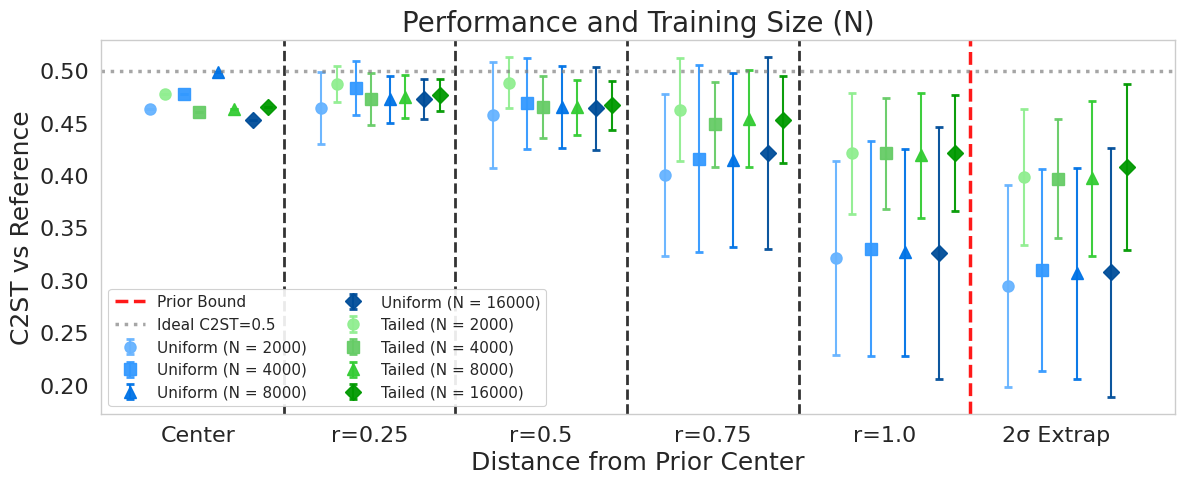

In [16]:
def plot_c2st_vs_distance_single_plot(c2st_results, figsize=(12, 5)):
    """Plot C2ST vs distance for all model configurations in a single plot"""
    distance_bins = ['center', 'r=0.25', 'r=0.5', 'r=0.75', 'r=1.0', '2sigma-extrap']
    bin_labels = ['Center', 'r=0.25', 'r=0.5', 'r=0.75', 'r=1.0', '2σ Extrap']
    x_positions = np.arange(len(distance_bins))
    plt.figure(figsize=figsize)

    # Define colors and markers for different configurations (with separation between uniform and tailed)
    # Narrower offsets to accommodate 6 bins instead of 4
    # Uniform models - shades of blue (shifted left)
    uniform_styles = {
        2000: {'color': '#66b3ff', 'marker': 'o', 'linestyle': '-', 'offset': -0.28},
        4000: {'color': '#3399ff', 'marker': 's', 'linestyle': '-', 'offset': -0.12+0.04},
        8000: {'color': '#0073e6', 'marker': '^', 'linestyle': '-', 'offset': 0.04+0.08},
        16000: {'color': '#004d99', 'marker': 'D', 'linestyle': '-', 'offset': 0.20+0.12}
    }

    # Tailed models - shades of green (shifted right)
    tailed_styles = {
        2000: {'color': '#90ee90', 'marker': 'o', 'linestyle': '--', 'offset': -0.19},
        4000: {'color': '#66cc66', 'marker': 's', 'linestyle': '--', 'offset': -0.03+0.04},
        8000: {'color': '#33cc33', 'marker': '^', 'linestyle': '--', 'offset': 0.13+0.08},
        16000: {'color': '#009900', 'marker': 'D', 'linestyle': '--', 'offset': 0.29+0.12}
    }

    # Plot Uniform models
    for n_sims in [2000, 4000, 8000, 16000]:
        model_name = f'Uniform-{n_sims}'
        if model_name in c2st_results:
            mean_c2st = []
            std_c2st = []
            valid_x = []

            for i, bin_name in enumerate(distance_bins):
                if c2st_results[model_name][bin_name]:  # Check if bin has data
                    vals = np.array(c2st_results[model_name][bin_name])
                    mean_c2st.append(np.mean(vals))
                    std_c2st.append(np.std(vals))
                    valid_x.append(x_positions[i] + uniform_styles[n_sims]['offset'])

            if mean_c2st:  # Only plot if we have data
                style = uniform_styles[n_sims]
                plt.errorbar(valid_x, mean_c2st, yerr=std_c2st,
                            fmt=style['marker'],
                            label=f'Uniform (N = {n_sims})',
                            color=style['color'],
                            capsize=3, capthick=2, linewidth=0, markersize=8,
                            barsabove=True, elinewidth=1.5, alpha=0.95)

    # Plot Tailed models
    for n_sims in [2000, 4000, 8000, 16000]:
        model_name = f'TailedUniform-{n_sims}'
        if model_name in c2st_results:
            mean_c2st = []
            std_c2st = []
            valid_x = []

            for i, bin_name in enumerate(distance_bins):
                if c2st_results[model_name][bin_name]:  # Check if bin has data
                    vals = np.array(c2st_results[model_name][bin_name])
                    mean_c2st.append(np.mean(vals))
                    std_c2st.append(np.std(vals))
                    valid_x.append(x_positions[i] + tailed_styles[n_sims]['offset'])

            if mean_c2st:  # Only plot if we have data
                style = tailed_styles[n_sims]
                plt.errorbar(valid_x, mean_c2st, yerr=std_c2st,
                            fmt=style['marker'],
                            label=f'Tailed (N = {n_sims})',
                            color=style['color'],
                            capsize=3, capthick=2, linewidth=0, markersize=8,
                            barsabove=True, elinewidth=1.5, alpha=0.95)

    # Add vertical dashed lines between distance bins
    for i in range(len(x_positions) - 1):
        separator_x = (x_positions[i] + x_positions[i + 1]) / 2
        # Last separator (between r=1.0 and 2sigma-extrap) is red and labeled
        if i == len(x_positions) - 2:
            plt.axvline(separator_x, color='red', linestyle='--', linewidth=2.5, 
                       alpha=0.9, zorder=0, label='Prior Bound')
        else:
            plt.axvline(separator_x, color='black', linestyle='--', linewidth=2.0, 
                       alpha=0.8, zorder=0)

    plt.axhline(0.5, color='gray', linestyle=':', linewidth=2.5, label='Ideal C2ST=0.5', alpha=0.7)
    plt.xticks(x_positions, bin_labels, fontsize=14)
    plt.xlabel('Distance from Prior Center', fontsize=18)
    plt.ylabel('C2ST vs Reference', fontsize=18)
    plt.title('Performance and Training Size (N)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(fontsize=11, loc='best', ncol=2, framealpha=0.9)
    plt.grid(False)
    plt.tight_layout()

    return plt.gcf()

# Create the single plot version
fig = plot_c2st_vs_distance_single_plot(c2st_results)

os.makedirs('experiment-figures', exist_ok=True)
plt.savefig('experiment-figures/c2st-vs-distance-by-nsims.pdf', dpi=300, bbox_inches='tight')
print("Saved: experiment-figures/c2st-vs-distance-by-nsims.pdf")

plt.show()